# Data fitting

Curve fitting is the process of constructing a curve, or mathematical function, that has the best fit to a series of eperimental data points.


## Loading data

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


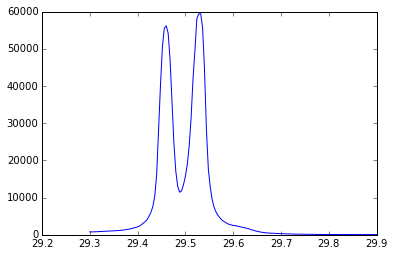

In [2]:
import silx.io
specfile = silx.io.open("data/31oct98.dat")
xdata = specfile["/22.1/measurement/TZ3"]
ydata = specfile["/22.1/measurement/If4"]
plot(xdata, ydata)

## Use of a builtin fitting function

The fitting function is a function of the data-point (xdata) and of a sert of parameters. Silx offers a set of usual fitting functions in module ``silx.math.fit.functions``.

In this example, we will use a gaussian function, ``sum_gauss``, whose parameters are *height*, *center* an *fwhm* (full-width at half maximum). The functions accepts a multiple number of these 3 base parameters, to fit a sum of multiple gaussian peaks.


In [3]:
from silx.math.fit.functions import sum_gauss

An essential part of the iterative fitting process is the choice of the initial set of parameters p0. Our initial estimate is that we have 2 peaks, centered at $x=29.45$ and at $x=29.55$, with amplitude $55000$ and $60000$ and with a full-width at half maximum of $0.03$.

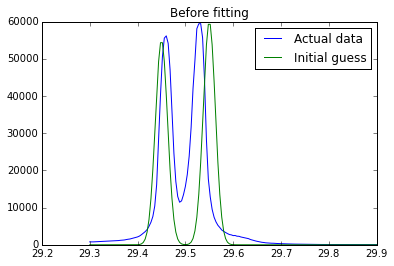

In [4]:
p0 = [55000., 29.45, 0.03,
      60000., 29.55, 0.03]
plot(xdata, ydata, label="Actual data")
plot(xdata, sum_gauss(xdata, *p0), label="Initial guess")
legend()
title("Before fitting")


## Fitting using silx


In [5]:
from silx.math.fit import leastsq

In [6]:
p, cov_matrix = leastsq(model=sum_gauss, xdata=xdata, ydata=ydata, p0=p0)
print(p)

[  5.65660023e+04   2.94595631e+01   3.19836859e-02   5.92015970e+04
   2.95275309e+01   3.54588691e-02]


In [7]:
%timeit p, cov_matrix = leastsq(model=sum_gauss, xdata=xdata, ydata=ydata, p0=p0)

100 loops, best of 3: 6.19 ms per loop


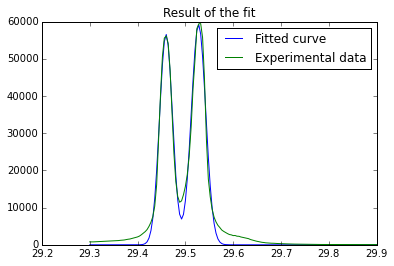

In [8]:
#Display the result of the fit
#plot(xdata, sum_gauss(xdata, *p0), label="Initial guess")
plot(xdata, sum_gauss(xdata, *p), label="Fitted curve")
plot(xdata, ydata,label="Experimental data")
legend()
title("Result of the fit")

Can we improve this by adding a small third peak at $x=29.61$ in our estimation?

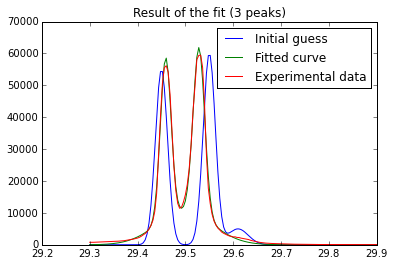

In [9]:
# estimate
p0 = [55000., 29.45, 0.03,
      60000., 29.55, 0.03,
      5000., 29.61, 0.05]
# fit
p, cov_matrix = leastsq(model=sum_gauss, xdata=xdata, ydata=ydata, p0=p0)

# plot
plot(xdata, sum_gauss(xdata, *p0), label="Initial guess")
plot(xdata, sum_gauss(xdata, *p), label="Fitted curve")
plot(xdata, ydata, label="Experimental data")
legend()
title("Result of the fit (3 peaks)")


It turns out that we were wrong regarding the position of our third peak, and about the amplitudes of all 3 peaks. The fit converged towards a much better 3-peak solution:

[  5.05170978e+04   2.94588874e+01   2.62330656e-02   5.27459196e+04
   2.95283488e+01   2.84759182e-02   1.03471962e+04   2.94988854e+01
  -1.37750880e-01]


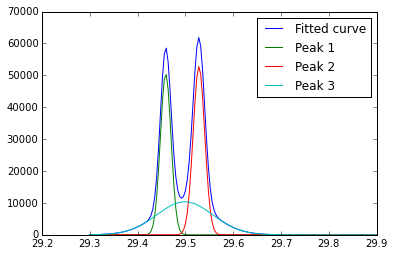

In [10]:
print(p)
plot(xdata, sum_gauss(xdata, *p), label="Fitted curve")
for i in range(3):
    plot(xdata, sum_gauss(xdata, *p[3*i:3*i+3]), label="Peak %d" % (i+1))
legend()

# Conclusion

Fitting curves requires the following steps:

* get the data points x_data and y_data
* define the fitting function as y_data = function (x_data, param)
* choose an initial guess for the set of parameters p0
* run the optimizer
* check the result.


# Fitting data with a background

Beyond simple curve fitting, *silx* offers more builtin fitting tools, to handle initial parameter estimation (including peak detection) and background estimation.

We need to import the ``FitManager`` class and the module defining builtin fit theories (``silx.math.fit.fittheories``).

## Loading data

Lets load an image, and sum all samples along the horizontal dimension to get a 1D curve.


/users/knobel/.local/lib/python3.4/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log


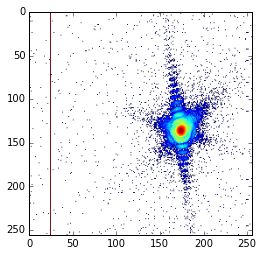

In [11]:
# import fabio
# img = fabio.open("data/medipix.edf").data

with silx.io.open("data/medipix.edf") as my_file:
    img = my_file["scan_0/instrument/detector_0/data"][0]
    
imshow(np.log(img))

Sum all samples for each row of the image, to get a curve.

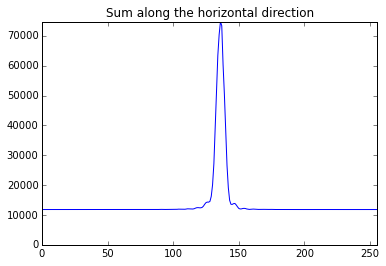

In [12]:
ydata = img.sum(axis=1)
xdata = numpy.arange(len(img),dtype="float")
plot(xdata, ydata)
axis([0, xdata.max(), 0, ydata.max()])
title("Sum along the horizontal direction")

## Setting up a FitManager

If we want to fit a single gaussian to this data, we clearly need to remove the constant background signal, at about $y=12000$.  

In [13]:
from silx.math.fit import FitManager, fittheories, bgtheories
fitman = FitManager()
fitman.setdata(x=xdata, y=ydata)
fitman.loadtheories(fittheories)
fitman.loadbgtheories(bgtheories)
fitman.settheory('Gaussians')
fitman.setbackground("Constant")

## Estimating initial parameters

Now that the FitManager is set-up, we need to estimate the initial parameters before running the fit. This is done by simply running the ``estimate`` method of fitmanager. This method uses the estimation function defined in fit theories. 

An automatic peak detection algorithm is used for gaussian-like fit theories. We do not need to specify the number of peaks or their position. The fwhm is estimated based on the higest peak (maximum value) in the data. 

The results are stored internaly in the FitManager instance as attribute ``fit_results``.
This attribute stores a list of dictionaries, one per parameter to be fitted.

In [14]:
fitman.estimate()

for param in fitman.fit_results:
    print("Estimated value for param %s: %f" % (param["name"], param["estimation"]))

Estimated value for param Constant: 11810.000000
Estimated value for param Height1: 63176.944734
Estimated value for param Position1: 135.955454
Estimated value for param FWHM1: 7.078567


The estimation function managed to find 1 peak and correctly estimated its gaussian parameters and the background level.

## Final fit

Running the fit is as simple as running the estimation.

Fitted value for param Constant: 11918.694707
Fitted value for param Height1: 63103.126632
Fitted value for param Position1: 135.955545
Fitted value for param FWHM1: 7.061779


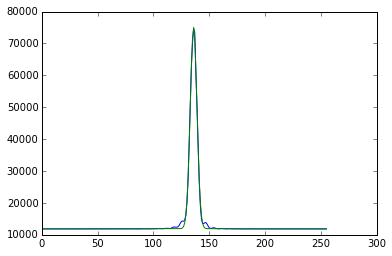

In [15]:
params, uncertainties, infodict = fitman.runfit()

for param in fitman.fit_results:
    print("Fitted value for param %s: %f" % 
          (param["name"], param["fitresult"]))
    
plot(xdata, ydata, label="Original data")
plot(xdata, params[0] + sum_gauss(xdata, *params[1:]), 
     label="Fitted data")

As you can see, parameters can be accessed as the first value returned by the ``runfit`` method, a simple list of raw values, or again as attribute ``fitman.fit_results``.

## More FitManager features

FitManager offers more features, such as:
 - setting constraints for parameters
 - advanced background models, beyond simple constant or linear: strip or snip backgrounds
 - adding custom fit and background theories, with customised estimation function, customized derivatives... 

# Exercise

    x = numpy.arange(10).astype(numpy.float64)
    y = 0.001 * x**3 + 25.1 * x**2 + 1.2 * x - 25
    
1. Fit degree-2 polynomial to this data
2. Fit a degree-3 polynomial to this data
3. Fit a degree-3 polynomial to this data using FitManager.
4. Print the chi-square value and number of iterations for all previous tasks.


+ Tip: For the 3-rd task, to add a model function to FitManager:

          from silx.math.fit import FitTheory
          from silx.math.fit import FitManager

          def poly3(x, a, b, c, d):
              return a * x**3 + b * x**2 + c*x + d
          
          my_poly3_theory = FitTheory(function=poly3, parameters=["a", "b", "c", "d"])
      
          fitman = FitManager()
          fitman.addtheory(name="my poly", theory=my_poly3_theory)
          ...
      

In [ ]:
# 1. Fill-in the blanks (...)
import numpy
from silx.math.fit import leastsq

# generate synthetic data
x = numpy.arange(10).astype(numpy.float64)
y = 0.001 * x**3 + 25.1 * x**2 + 1.2 * x - 25

# define the model function
def poly2(x,...):
    return ...

# define initial estimated parameters
p0 = ...

# Run the fit
...

# print the results (optimized parameters)
...




In [ ]:
# 2.
import numpy
from silx.math.fit import leastsq

x = numpy.arange(10).astype(numpy.float64)
y = 0.001 * x**3 + 25.1 * x**2 + 1.2 * x - 25

# define the model function
def poly3(...):
    return ...

# define initial estimated parameters  
p0 = ...

# Run the fit
...

# print the results (optimized parameters)
...



In [ ]:
# 3.
import numpy

x = numpy.arange(10).astype(numpy.float64)
y = 0.001 * x**3 + 25.1 * x**2 + 1.2 * x - 25

from silx.math.fit import FitTheory
from silx.math.fit import FitManager

def poly3(x, a, b, c, d):
    return a * x**3 + b * x**2 + c*x + d

# define a fit theory for this function and these 4 parameters
my_poly3_theory = FitTheory(...)

fitman = FitManager()
# add the theory to fitma
fitman....
# select the theory
fitman....
# set the data (x, y)
fitman....

# FitManager.estimate() returns an array of initial parameters
p0 = fitman.estimate()
# ... and as we didn't define an estimation function, it will be an array of ones.
print("Estimated parameters: ", p0)

# FitManager.runfit() returns the same data as leastsq(..., full_output=True) 
p, cov, info = fitman.runfit()

print("Parameters [a, b, c, d]: " + str(p))

for param in fitman.fit_results:
    print("parameter %s: %f" % (param["name"], param["fitresult"]))


In [ ]:
# 4.

p, cov_matrix, info = leastsq(poly2, x, y, p0, ...)

# print the number of iterations and the chisq
print(...)
print(...)

## Background filters

Besides analytical polynomial background theories  (*Constant, Linear, Degree 2 Polynomial,Degree 3 Polynomial, ...*), two non-analytical background filters are provided for the fit manager: *Strip* and *Snip*.

![BackgroundFilters](strip_snip.png)


### Strip filter

The goal of the strip filter is to *strip* away narrow peaks from the data in order to be left only with the wide *background* signal. By subtracting the background from the data, one is left with only the narrow peaks to be fitted.

Given a sample index $i$, and a width $w$, the average $m(i, w)$ for the data $y$ is calculated:

$m(i, w) = 0.5 * (y(i + w) + y(i - w))$

If $y(i) > m(i, w)$, then $y(i)$ is replaced by $m(i, w)$. 

The procedure is repeated $N$ iterations.

A *Savitsky-Golay* filter can be applied first, to suppress the random noise.


This simple filter is defined by two or three parameters:
 - the strip width ($w$)
 - the number of iterations ($N$)
 - the Savitsky-Golay smoothing width


### Snip filter

The concept of this filter is similar to the strip.

A sample will be iteravely compared to it's neighbors up to a given distance (snip width $w$, in samples).

The algorithm is defined by only one parameter ($w$), or 2 parameters if a smoothing filter is to be applied prior to the snip. 

It is generally faster than the strip filter.

### Usage




In [16]:

fitman = FitManager()
fitman.setdata(x=xdata, y=ydata)
fitman.loadtheories(fittheories)
fitman.loadbgtheories(bgtheories)
fitman.settheory('Gaussians')
fitman.setbackground("Strip")
fitman.configure(SmoothingFlag=False, StripWidth=2, StripIterations=2000) 
fitman.estimate()
params, uncertainties, infodict = fitman.runfit()

In [17]:
print(params)
# StripWidth, StripIterations, heigth, position, fwhm

[  2.00000000e+00   2.00000000e+03   6.31691713e+04   1.35955479e+02
   7.07681274e+00]


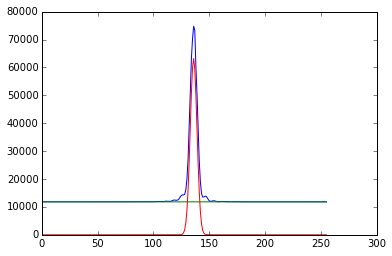

In [18]:
plot(xdata, ydata, label="original data")

from silx.math.fit.filters import strip
strip_bg = strip(ydata, w=2, niterations=2000)
plot(xdata, strip_bg, label="strip bg")

plot(xdata, params[0] + sum_gauss(xdata, *params[2:]), 
     label="Fitted data")